# Python Glacier Evolution simulation demo

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
20241025<br><br>
To showcase the simulation functionality of PyGEM, let's run a batch of CMIP6 simulations for Kaskawulsh glacier and look at the projected glacier runoff


In [1]:
### imports ###
import os, sys, glob
# pygem imports
import pygem.setup.config as config
# check for config
config.ensure_config()
# read the config
pygem_prms = config.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                    # the appropriate location. If any errors occur, check this first.

In [2]:
# specify glacier numbember (RGI6 id), we'll run Kaskawulsh in the Canadian Yukon
glac_no = 1.16201
# specify which SSP scenarios we wish to run
scenarios=['ssp245','ssp370','ssp585']
# get list of all CMIP6 GCMs available on your machine
gcms = glob.glob(f"{pygem_prms['root']}/{pygem_prms['climate_paths']['cmip6_relpath']}/*/*{scenarios[0]}*.nc")
gcms = list(set([gcm.split('/')[-2] for gcm in gcms]))

# optional, if only GCM(s) desired:  gcms = [x for x in gcms if any(substring in x for substring in ['CESM2', 'GFDL', 'MPI'])]

Now loop through all scenarios/GCM pairs

In [3]:
for gcm in gcms:
    for scenario in scenarios:
        # Use !run_simulation to execute PyGEM's run_simulation.py script. Change start and endyear if desired.
        !run_simulation -rgi_glac_number {glac_no} -gcm_startyear 2000 -gcm_endyear 2100 -gcm_name {gcm} -scenario {scenario} -option_dynamics OGGM

2024-10-30 12:12:07: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-10-30 12:12:07: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-10-30 12:12:07: oggm.cfg: Multiprocessing: using all available processors (N=10)
2024-10-30 12:12:07: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2024-10-30 12:12:07: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2024-10-30 12:12:07: oggm.cfg: PARAMS['trapezoid_lambdas'] changed from `2.0` to `1`.
Processing: FGOALS-f3-L ssp245
1 glaciers in region 1 are included in this model run: ['16201']
This study is focusing on 1 glaciers in region [1]
FGOALS-f3-L : RGI60-01.16201
2024-10-30 12:12:09: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-10-30 12:12:09: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-10-30 12:12:09: oggm.cfg: Multiprocessing: using all available processors (N=10)
2024-10

Excellent! If our simulations ran correctly, we should have a set of outputs for the CMIP6 multi-GCM ensemble for ssps 245, 370, 585. Let's investigate the results, with the goal of plotting the runoff, mass, area, and cross sectional geometry.

In [4]:
### more imports ###
import xarray as xr
import matplotlib.pyplot as plt
import json
import numpy as np
plt.rcParams["font.family"] = "arial"
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8

In [5]:
# specify where to look for results
simdir = f"{pygem_prms['root']}/Output/simulations/"

In [6]:
# create dictionary to hold stats on results for variables of interest for each scenario (runoff, mass, area)
results = {}

# loop through scenarios
for scenario in scenarios:
    results[scenario] = {}
    # get all GCM outputs for given scenario
    fns = glob.glob(simdir + f"/{str(glac_no).split(".")[0].zfill(2)}/*/{scenario}/stats/{glac_no}*.nc")
    # initialize list to hold annual runoff values
    annual_runoff = []
    # note, PyGEM outputs monthly runoff, so we'll resample to annual values by summing
    k = 'glac_runoff_monthly'
    for f in sorted(fns):
        ds = xr.open_dataset(f)[k][0]
        # runoff is monthly, so sum to yealy vals
        # print(ds.time)
        ds_sum = ds.resample(time='YE').sum('time')
        # append annual runoff to list
        annual_runoff.append(ds_sum.values.tolist())
    # stack all GCMs annual runoff
    stacked_runoff = np.vstack(annual_runoff)
    # get some metrics of multi-GCM results (mean, standard deviation, min, max)
    mean_runoff = np.nanmean(stacked_runoff,axis=0)
    std_runoff = np.nanstd(stacked_runoff,axis=0)
    min_runoff = np.nanmin(stacked_runoff, axis=0)
    max_runoff = np.nanmax(stacked_runoff, axis=0)
    # add metrics to dictionary
    results[scenario]['mean_runoff'] = mean_runoff.tolist()
    results[scenario]['std_runoff'] = std_runoff.tolist()
    results[scenario]['min_runoff'] = min_runoff.tolist()
    results[scenario]['max_runoff'] = max_runoff.tolist()

    # initialize list to hold annual area values
    annual_area = []
    k = 'glac_area_annual'
    for f in sorted(fns):
        ds = xr.open_dataset(f)[k][0]
        # pull annual area and add to list
        # note, PyGEM annual area is the area at the beginning of each model year
        # to align with plotting the total runoff from each year, we'll take index [1:],
        # inidicating we're analyzing values for the end of each model year
        annual_area.append(ds.values[1:].tolist())
    stacked_area = np.vstack(annual_area)
    # get some metrics of multi-GCM results (mean, standard deviation, min, max)
    mean_area = np.nanmean(stacked_area,axis=0)
    std_area = np.nanstd(stacked_area,axis=0)
    min_area = np.nanmin(stacked_area, axis=0)
    max_area = np.nanmax(stacked_area, axis=0)
    # add metrics to dictionary
    results[scenario]['mean_area'] = mean_area.tolist()
    results[scenario]['std_area'] = std_area.tolist()
    results[scenario]['min_area'] = min_area.tolist()
    results[scenario]['max_area'] = max_area.tolist()

    # initialize list to hold annual mass values
    annual_mass = []
    k = 'glac_mass_annual'
    for f in sorted(fns):
        ds = xr.open_dataset(f)[k][0]
        # pull annual mass and add to list
        # note, PyGEM annual mass is the area at the beginning of each model year
        # to align with plotting the total runoff from each year, we'll take index [1:],
        # inidicating we're analyzing values for the end of each model year
        annual_mass.append(ds.values[1:].tolist())
        # get model years - note indexing [:-1]
        # for a simulation that ran from 2000 thru 2100
        year = (ds.year.values[:-1:]).tolist()
    stacked_mass = np.vstack(annual_mass)
    # get some metrics of multi-GCM results (mean, standard deviation, min, max)
    mean_mass= np.nanmean(stacked_mass,axis=0)
    std_mass = np.nanstd(stacked_mass,axis=0)
    min_mass = np.nanmin(stacked_mass, axis=0)
    max_mass = np.nanmax(stacked_mass, axis=0)
    # add metrics to dictionary
    results[scenario]['std_mass'] = std_mass.tolist()
    results[scenario]['mean_mass'] = mean_mass.tolist()
    results[scenario]['min_mass'] = min_mass.tolist()
    results[scenario]['max_mass'] = max_mass.tolist()

In [7]:
### optional: save results to json file ###
# with open('/Users/btober/Desktop/kaskawulsh_CMIP6_mass_area_runoff_2000_2100.json','w') as f:
#     json.dump(results,f)

Create three panel plot with normalized mass, area, and runoff for each scenario (multi-GCM mean and range)

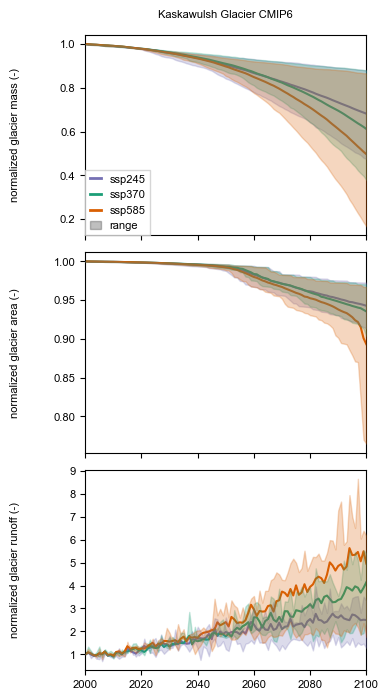

In [8]:
# initialize figure
fig,ax = plt.subplots(3,figsize=(4,7),sharex=True)
# define colors - 3 color-blind friendly hex colors selected from colorbrewer2.org/
c=['#7570b3','#1b9e77','#d95f02']
# define transparency
alpha=.25

# loop through scenarios, plot normalized mass, area, and runoff, as well as inter-GCM range of each
for i, scenario in enumerate(scenarios):
    ax[0].plot(year,np.asarray(results[scenario]['mean_mass'])/results[scenario]['mean_mass'][0],zorder=2,c=c[i], label=scenario)
    ax[0].fill_between(year,
                        (np.asarray(results[scenario]['min_mass']) / results[scenario]['min_mass'][0]),
                        (np.asarray(results[scenario]['max_mass'])/ results[scenario]['max_mass'][0]),
                        alpha=alpha,
                        zorder=3,
                        color=c[i])
    ax[1].plot(year,np.asarray(results[scenario]['mean_area'])/results[scenario]['mean_area'][0],zorder=2,c=c[i])
    ax[1].fill_between(year,
                        (np.asarray(results[scenario]['min_area']) / results[scenario]['min_area'][0]),
                        (np.asarray(results[scenario]['max_area']) / results[scenario]['max_area'][0]),
                        alpha=alpha,
                        zorder=3,
                        color=c[i])
    ax[2].plot(year,np.asarray(results[scenario]['mean_runoff'])/results[scenario]['mean_runoff'][0],zorder=2,c=c[i])
    ax[2].fill_between(year,
                        (np.asarray(results[scenario]['min_runoff']) / results[scenario]['min_runoff'][0]),
                        (np.asarray(results[scenario]['max_runoff']) / results[scenario]['max_runoff'][0]),
                        alpha=alpha,
                        zorder=3,
                        color=c[i])

# "fake" filled region to indicate range on legend
ax[0].fill_between([],[],color='k',alpha=alpha,label='range')

# create legend
leg = ax[0].legend(fancybox=False,borderaxespad=0,handlelength=1)
# increase linewidths in legend

for line in leg.get_lines():
    line.set_linewidth(2)
# set x axis limits to temporal extent of our data
ax[0].set_xlim([2000,2100])
# create x and y axis labels
ax[0].text(-0.25, 0.5, 'normalized glacier mass (-)', va='center', ha='center', rotation=90, transform=ax[0].transAxes)
ax[1].text(-0.25, 0.5, 'normalized glacier area (-)', va='center', ha='center', rotation=90, transform=ax[1].transAxes)
ax[2].text(-0.25, 0.5, 'normalized glacier runoff (-)', va='center', ha='center', rotation=90, transform=ax[2].transAxes)
# title
ax[0].text(.5, 1.1, 'Kaskawulsh Glacier CMIP6', va='center', ha='center', rotation=0, transform=ax[0].transAxes)
fig.tight_layout()
# save
# fig.savefig(f'/Users/btober/Desktop/kaskawulsh_cmip6_mass_area_runoff_mean_range.png',dpi=400)

Perhaps we're interested in the average runoff for each 20-year period???

In [9]:
# pull out the multi-GCM SSP585 mean annual runoff for Kaskawulsh glacier for each 20-year period
periods = [(2001,2020),(2021,2040),(2041,2060),(2061,2080),(2081,2100)]
for i, scenario in enumerate(scenarios):
    print(scenario)
    for period in periods:
        inds = [year.index(val) for val in period]
        runoff_avg = np.mean(results[scenario]['mean_runoff'][inds[0]:inds[1]+1])
        runoff_sig = np.std(results[scenario]['mean_runoff'][inds[0]:inds[1]+1])
        print(f"{period[0]}:{period[1]} = {round(1e-9*runoff_avg,3)} +/- {round(1e-9*runoff_sig,3)} km3/yr")

ssp245
2001:2020 = 0.851 +/- 0.075 km3/yr
2021:2040 = 1.174 +/- 0.093 km3/yr
2041:2060 = 1.571 +/- 0.156 km3/yr
2061:2080 = 1.807 +/- 0.122 km3/yr
2081:2100 = 2.071 +/- 0.096 km3/yr
ssp370
2001:2020 = 0.85 +/- 0.08 km3/yr
2021:2040 = 1.127 +/- 0.123 km3/yr
2041:2060 = 1.557 +/- 0.207 km3/yr
2061:2080 = 2.134 +/- 0.202 km3/yr
2081:2100 = 2.837 +/- 0.232 km3/yr
ssp585
2001:2020 = 0.854 +/- 0.096 km3/yr
2021:2040 = 1.203 +/- 0.114 km3/yr
2041:2060 = 1.82 +/- 0.258 km3/yr
2061:2080 = 2.641 +/- 0.325 km3/yr
2081:2100 = 3.732 +/- 0.351 km3/yr


Create a plot of the glacier geometry evolution for each scenario comparing the beginning of the simulation to the end

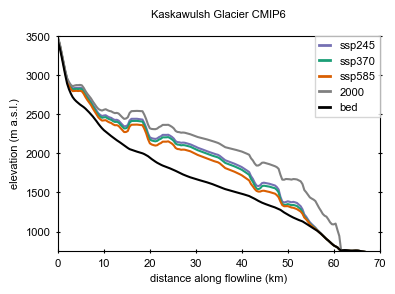

In [10]:
# initialize figure
fig,ax = plt.subplots(1,figsize=(4,3))
# define colors - 3 color-blind friendly hex colors selected from colorbrewer2.org/
c=['#7570b3','#1b9e77','#d95f02']

# loop through scenarios, get final model year thickness for each GCM, then take mean across all GCMs
for i, scenario in enumerate(scenarios):
    fns = glob.glob(simdir + f"/{str(glac_no).split(".")[0].zfill(2)}/*/{scenario}/binned/{glac_no}*.nc")
    thicks = []
    for j,f in enumerate(sorted(fns)):
        ds = xr.open_dataset(f)                            # open netcdf dataset
        thick = ds.bin_thick_annual[0].values[:,-1]        # pull thickness from last year. note, -1 index indicates last model year
        thicks.append(thick)                               # append final year's thickness to list of all GCMs 
    # stack thickness and get mean across all GCMs
    stacked_thick = np.vstack(thicks)
    mean_thick = np.nanmean(stacked_thick,axis=0)
    # plot mean thickness
    ax.plot(ds.bin_distance[0].values*1e-3, ds.bin_surface_h_initial[0].values+mean_thick,ls='-',c=c[i], alpha=1, label=scenario)
# plot initial thickness
ax.plot(ds.bin_distance[0].values*1e-3, ds.bin_surface_h_initial[0].values+ds.bin_thick_annual[0].values[:,0],ls='-',c='gray',label='2000')
# plot bed
ax.plot(ds.bin_distance[0].values*1e-3, ds.bin_surface_h_initial[0].values,ls='-',c='k',label='bed')
# create legend object
leg = ax.legend(fancybox=False,borderaxespad=0,handlelength=1)
# increase linewidths in legend
for line in leg.get_lines():
    line.set_linewidth(2)
# set x and y axis limits to zoom in on area of interest
ax.set_xlim([0,70])
ax.set_ylim([750,3500])
# create x and y axis labels
ax.set_ylabel('elevation (m a.s.l.)')
ax.set_xlabel('distance along flowline (km)')
# modify ticks as desired
ax.tick_params(axis='both', which='major', direction='inout', right=True)
ax.tick_params(axis='both', which='minor', direction='in', right=True)
# title
ax.text(.5, 1.1, f'Kaskawulsh Glacier CMIP6', va='center', ha='center', rotation=0, transform=ax.transAxes)
fig.tight_layout()
# save
# fig.savefig(f'/Users/btober/Desktop/kaskawulsh_cmip6_mean_geom.png')